In [2]:
import findspark
findspark.init('/opt/spark')
# importamos los packetes necesarios
from pyspark import SparkContext
from pyspark.streaming import StreamingContext
from pyspark.sql import SQLContext
from pyspark.sql.functions import desc

### Inicializacion del Contexto Spark

Seguidamente inicializamos nuestro SparkContext como punto de entrada a cualquier funcionalidad de Spark.\

Cuando corremos una applicacion de Spark, un programa conductor inicia, el cual contiene la funcion principal de nuestro SparkContext y es inicializado aqui. Un Contexto Spark representa la coneccion a un cluster, que puede ser usada para crear RDD's, acumuladores y transmitir estas variables en el cluster.


In [3]:
sc = SparkContext()
# inicializamos el StreaminContext con intervalos batch cada 10 segundos, y luego iniciamos el sqlcontext
ssc = StreamingContext(sc, 10)
sqlContext = SQLContext(sc)

**En el siguiente paso asignamos nuestra fuente de entrada y entonces ponemos todos estos datos recibidos en lineas**



In [4]:
# iniciamos el streaming de texto desde un socket TCP fuente:
socket_stream = ssc.socketTextStream("127.0.0.1", 5555)

#lineas de tweets en el socket durante una ventana de 60 segundos
lines = socket_stream.window(60)

Es importante mencionar que vamos a utilizar el mismo puerto que en la applicacion que colecta nuestros tweets, y la direccion IP es la misma, por que estamos corriendo todo esto en nuestra maquina local. Ademas de estos estamos utilizando la funcion **window()** para determinar que estamos analyzando los tweets cada 60 segundos para ver el top 10 de los hastags durante este tiempo.

Aqui hay una imagen que nos permite entender mejor como la funcion **window()** funciona en Spark:


![](image1.jpeg)

ahora que ya tenemos todos los pre-requisitos listos, veamos como limpiamos los tweets que comienzan con **#** y salvamos el top 10 en una tabla temporal de SQL:


In [5]:
# una tupla para assignar los nombres
from collections import namedtuple
fields = ("hashtag", "count" )
Tweet = namedtuple( 'Tweet', fields )
# aqui aplicamos diferentes operaciones en los tweets and y los salvamos en una tabla temporal sql
( lines.flatMap( lambda text: text.split( " " ) ) #lo partimos y creamos una lista
  #Buscamos por hastags #
  .filter( lambda word: word.lower().startswith("#") ) 
  .map( lambda word: ( word.lower(), 1 ) ) # hacemos minuscula la palabra
  .reduceByKey( lambda a, b: a + b ) 
 # guardmos en el objeto Tweet
  .map( lambda rec: Tweet( rec[0], rec[1] ) )
 #los ordenamos en un dataframe
  .foreachRDD( lambda rdd: rdd.toDF().sort( desc("count") )
 #Registramos solo los top 10 en una tabla              
  .limit(10).registerTempTable("tweets") ) )

we created a namedtuple object to save the tags with their counts. next we used flatmap() to create an array of tokenized tweets. we are using lambda functions because they require less memory and run faster. after that, we filter tweets that do not start with #. foreachRDD() is an important output function in pySpark that can help run faster operation on the RDDs. here we apply it to each RDD to convert it to a dataframe and finally we save it to a temporary table called “tweets”.

## Ahora, corremos tweetsreceiver.py  y despues iniciamos nuesto SparkStreamingContext 'scc.start()'

In [6]:
# iniciamos el streaming y esperamos unos minutos para colectar suficientes tweets
ssc.start()

next we import our visualization libraries and draw the graph for top 10 #tags in “Football” topic. here we run our streaming to check the top 10 #tags every minute only few (5) times just for the sake of learning purpose and you can see that the # tags do not change that often but if you want to see better results, you can keep it running for a while:

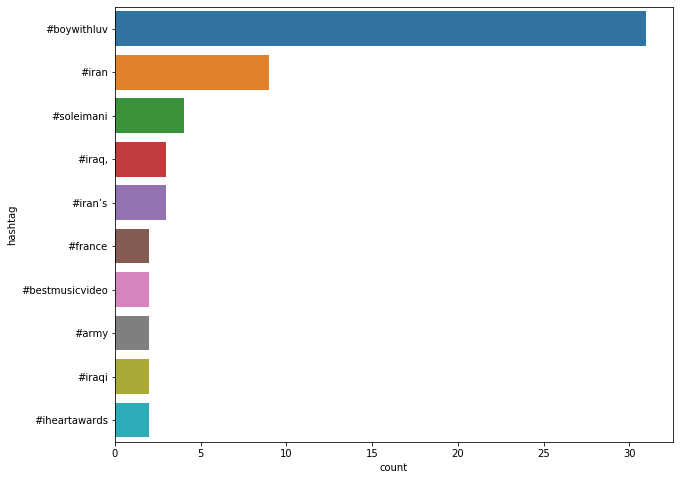

5


In [8]:
# importamos las librerias necesarias para nuestas visualizaciones
import time
from IPython import display
import matplotlib.pyplot as plt
import seaborn as sns
import pandas
%matplotlib inline
count = 0
while count < 5:
    
    time.sleep(5)
    top_10_tags = sqlContext.sql( 'Select hashtag, count from tweets' )
    top_10_df = top_10_tags.toPandas()
    display.clear_output(wait=True)
    plt.figure( figsize = ( 10, 8 ) )
    sns.barplot( x="count", y="hashtag", data=top_10_df)
    plt.show()
    count = count + 1
    print(count)